# Betting the NFL Over/Under - A Data Science Perspective
## Modeling

**Import all the relevant packages.** 

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import xgboost as xgb
import matplotlib.ticker as tick
%matplotlib inline
from sklearn import linear_model, ensemble
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GroupKFold, ParameterGrid
from sklearn.feature_selection import RFE, RFECV
from sklearn.preprocessing import RobustScaler

**Define functions used in notebook.**

In [11]:
def get_data():
# Obtains the features and target variable from the pickle file
    path = 'data/df_2010_2019_5wk.pkl'
    with open(path,'rb') as f:
        dfgame = pickle.load(f)
    X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
    X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf','Week','Year'],axis=1)
    y = dfgame['Tot_Pts']
    return X, y

def get_coef(coef_,cols):
# Sorts and returns feature coefficients
    coef = pd.DataFrame(coef_, cols, columns=['Coefficient'])
    ind=np.flip(np.argsort(abs(coef_)))
    return coef.iloc[ind]

def x_tk_fmt(x,y):
# Function to add '+' to tickmarks
    if x > 0:
        return '{:+d}'.format(int(x))
    else:
        return '{:d}'.format(int(x))

def plot_coef(OLS,fig,ax,p_thresh=None):
# Plots OLS feature coefficients
    if p_thresh is not None:
        mask = OLS.pvalues[1:] < p_thresh
        params = OLS.params[1:][mask]
        conf_int = OLS.conf_int()[1:][mask]
    else:
        params = OLS.params[1:]
        conf_int = OLS.conf_int()[1:]
        
    err_series = params - conf_int[0]
    coef_df = pd.DataFrame({'coef': params.values,
                            'err': err_series.values,
                            'varname': err_series.index.values
                           }).sort_values(by='coef',ascending=False)
#    coef_df.plot(x='varname', y='coef', kind='bar', 
#                 ax=ax, color='none', 
#                 yerr='err', legend=False)
    coef_df.plot.bar(x='varname', y='coef', 
                 ax=ax, color='none', 
                 yerr='err', legend=False, capsize=6)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='s', s=120, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
    ax.xaxis.set_ticks_position('none')
    return

def ou_accuracy(actu,pred,thresh=0):
# Returns the Over/Under accuracy of the prediction results and the percentage of games included when a
# threshold is used // thresh = 0 -> no threshold assumed
    with open('data/df_2000_2019.pkl','rb') as f:
        dfall = pickle.load(f)
    ou = dfall.loc[actu.index,'Over_Under']
        
    if not((len(actu) == len(pred)) & (len(pred) == len(ou))):
        if (len(actu) != len(pred)):
            raise ValueError(f'Length mismatch among arguments: actual != predicted ({len(actu)} != {len(pred)})')
        else:
            raise ValueError(f'Length mismatch among arguments: predicted != Over/Under ({len(pred)} != {len(ou)})')
    else:
        if (thresh == 0):
            corr = (((actu<ou) & (pred<ou)).sum() + ((actu>ou) & (pred>ou)).sum())
            tot = (pred<ou).sum() + (pred>ou).sum()
            pctofgames = 1.0
        else:
            if thresh > 0:
                mask = (pred-ou) >= thresh
                actu = actu[mask]
                pred = pred[mask]
                ou = ou[mask]
                corr = (((actu>ou) & (pred>ou)).sum())
                tot = (pred>ou).sum()
            else:
                mask = (pred-ou) <= thresh
                actu = actu[mask]
                pred = pred[mask]
                ou = ou[mask]
                corr = (((actu<ou) & (pred<ou)).sum())
                tot = (pred<ou).sum()
            pctofgames = tot/len(mask)
    return corr/tot,pctofgames

**Set of routines governing the sorting, grouping, and train/test splitting of data in this study**

In [5]:
from math import floor 
  
def tt_split(X,y,train_ratio,valid_ratio=0.0,seed=None,val=False):
# Train/test splitting function used in this study
    X, y = shufflesort(X,y,seed)
    if val:
        ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
        ygrp = group_labels(y,ratio,seed=seed)
        X_train, X_valid, y_train, y_valid = split_labels(X,y,ygrp,binwidth,ratio)

        ratio = 1-(valid_ratio/(1-train_ratio))
        binwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
        ygrp = group_labels(y_valid,ratio,seed=seed)
        X_val, X_test, y_val, y_test = split_labels(X_valid,y_valid,ygrp,binwidth,ratio)
        return X_train, X_val, X_test, y_train, y_val, y_test 
    else:
        test_ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(test_ratio),deno_decimalToFraction(1-test_ratio))
        ygrp = group_labels(y,test_ratio,seed=seed)
        X_train, X_test, y_train, y_test = split_labels(X,y,ygrp,binwidth,test_ratio)

        return X_train, X_test, y_train, y_test


def group_labels(y,ratio,seed=None):
# Randomly groups sorted labels based on train/test ratios
    np.random.seed(seed=seed)
    length = len(y)
    grpwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
    reg_grps = int(length/grpwidth) 
    grp=np.empty(length,dtype=int)
    for i in range(reg_grps):
        b_idx = i * grpwidth
        f_idx = b_idx + grpwidth
        grp[b_idx:f_idx] = np.random.choice(grpwidth,grpwidth,replace=False)
    grp[f_idx:length] = np.random.choice(grpwidth,length-f_idx,replace=False)
    return grp

def split_labels(X,y,grp,binwidth,ratio):
# Splits labels into train, test populations based on grouping
    sel = np.isin(grp,np.arange(round(binwidth*ratio)))
    y_test = y[sel]
    X_test = X[sel]
    sel = np.isin(grp,np.arange(round(binwidth*ratio)),invert=True)
    y_train = y[sel]
    X_train = X[sel]        
    return X_train, X_test, y_train, y_test

def gcd(a, b): 
# Recursive function to return GCD of a and b 
      
    if (a == 0): 
        return b 
    elif (b == 0): 
        return a 
    if (a < b): 
        return gcd(a, b % a) 
    else: 
        return gcd(b, a % b) 

def deno_decimalToFraction(number):
# Returns denominator of fraction converted from decimal   
      
    # Fetch integral value of the decimal 
    intVal = floor(number) 
  
    # Fetch fractional part of the decimal 
    fVal = number - intVal 
  
    # Consider precision value to 
    # convert fractional part to 
    # integral equivalent 
    pVal = 1000000000
  
    # Calculate GCD of integral 
    # equivalent of fractional 
    # part and precision value 
    gcdVal = gcd(round(fVal * pVal), pVal) 
  
    # Calculate num and deno 
    num= round(fVal * pVal) // gcdVal 
    deno = pVal // gcdVal 

#     # Print the fraction 
#     print((intVal * deno) + num, "/", deno) 
  
    return deno 
  

def shufflesort(X,y,seed=None):
# Sorts dataset by label and shuffles labels with the same value
    np.random.seed(seed=seed)
    y_sorted = y.reset_index(drop=True).sort_values()
    idx = y_sorted.index.to_numpy()
    vc = y_sorted.value_counts()
    vals = list(vc[vc > 1].index)
    for val in vals:
        b_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[0])   # First index of value
        f_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[-1])  # Last index of value
        idx[b_idx:f_idx+1] = np.random.permutation(idx[b_idx:f_idx+1])     # Permute order of indices for value
    y_sorted = y_sorted.reindex(idx)
    y = y.iloc[y_sorted.index]
    X = X.iloc[y_sorted.index]
    return X,y

In [12]:
# dfgame represents the averaged data and individual gamedata used in the analysis
path = 'data/df_2010_2019_5wk.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

### Feature Engineering

**Correlation heatmap of the top 16 features in absolute correlation coefficient with** *Total Points* **along with** *Over/Under*

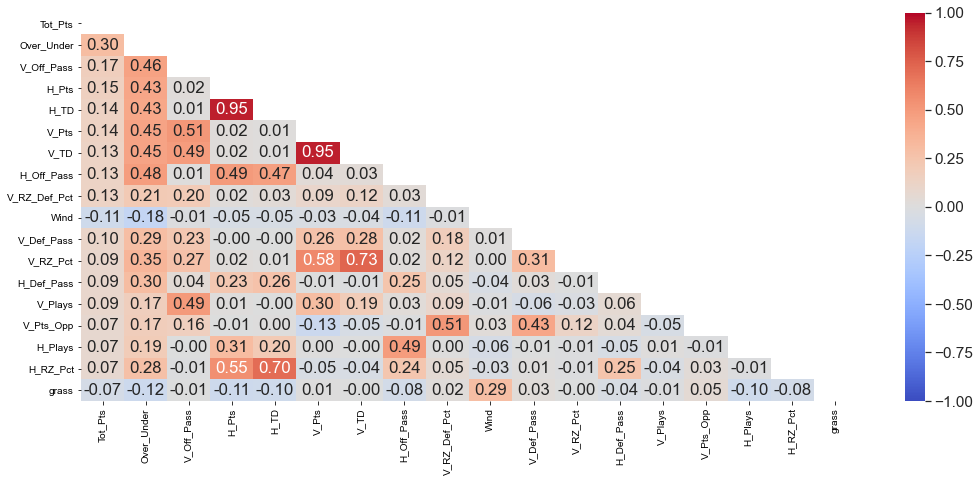

In [6]:
fig12 = plt.figure(figsize=(15,7))
ax = fig12.add_subplot(1,1,1)
cols = dfgame.drop(['Home_Team','Vis_Team','H_Game','V_Game'],axis=1).columns

corrs = [np.abs(dfgame['Tot_Pts'].corr(dfgame[col])) for col in cols]
sortcorr = sorted(corrs,reverse=True)
mapa = {ind:corrs.index(value) for ind,value in enumerate(sortcorr)}
newcols = [cols[mapa[ind]] for ind in range(len(cols))]

Top = dfgame[newcols[0:18]]
mask = np.triu(Top.corr())
sns.set(font_scale=1.4)
sns.heatmap(Top.corr(),vmin=-1.0,center=0,vmax=1.0,mask=mask,
            annot=True,cmap='coolwarm',fmt='.2f')
fig12.tight_layout()

In [8]:
X, y = get_data()
X.columns

Index(['H_Pts', 'H_Pts_Opp', 'V_Pts', 'V_Pts_Opp', 'H_Off_Pass',
       'H_Pass_Metric', 'V_Off_Pass', 'V_Pass_Metric', 'H_Off_Rush',
       'H_Rush_Metric', 'V_Off_Rush', 'V_Rush_Metric', 'H_Def_Pass',
       'V_Def_Pass', 'H_Def_Rush', 'V_Def_Rush', 'H_TD', 'V_TD', 'H_TD_on_Def',
       'V_TD_on_Def', 'H_FG_Pct', 'V_FG_Pct', 'H_RZ_Pct', 'V_RZ_Pct',
       'H_RZ_Def_Pct', 'V_RZ_Def_Pct', 'H_Poss', 'V_Poss', 'H_Plays',
       'V_Plays', 'H_TO_Gain', 'V_TO_Gain', 'H_TO_Lost', 'V_TO_Lost',
       'H_Yds_Pen', 'V_Yds_Pen', 'H_Sacks_Def', 'V_Sacks_Def',
       'H_Tackles_Loss', 'V_Tackles_Loss', 'H_Kickret', 'V_Kickret',
       'H_Puntret', 'V_Puntret', 'Temperature', 'Wind', 'grass', 'dome'],
      dtype='object')

### Scaling & Feature Importance

**Apply scaler that is robust to outliers**

In [7]:
robust = RobustScaler()

**Set training ratio and random seed**

In [8]:
train_ratio = 0.75
seed = 37

**Determine feature coefficients and importance by removing features with high multicollinearity**

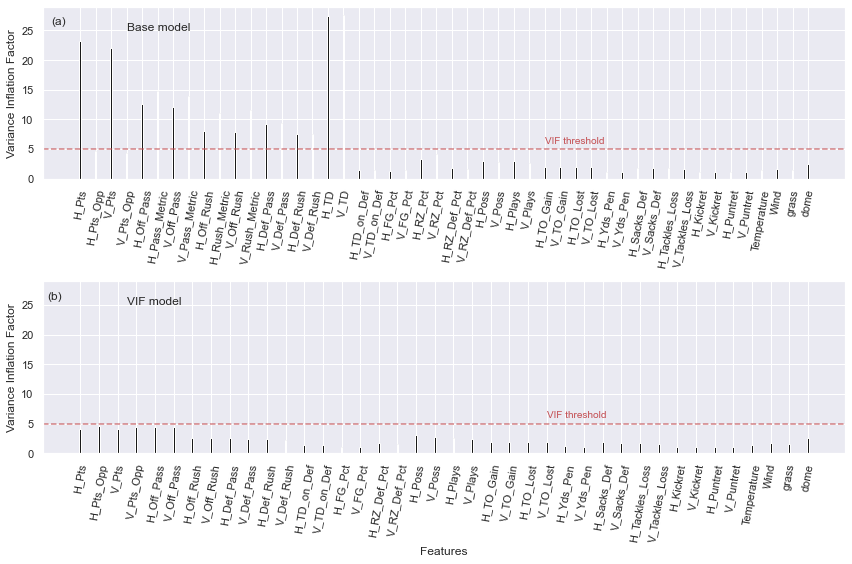

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set(font_scale=1.0)

X, y = get_data()
# All the features are initially considered
X_train, X_test, y_train, y_test  = tt_split(X, y, train_ratio, seed=seed, val=False)

# Plot VIF for all study features
vif = pd.DataFrame()
vif['Features'] = X_train.columns
xarray = sm.add_constant(X_train.values)
vif['VIF Factor'] = [variance_inflation_factor(xarray,i) for i in range(1,len(X_train.columns)+1)]
fig13, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
ax1.bar(vif['Features'],vif['VIF Factor'],width=0.1,color='k')
ax1.tick_params(axis='x',labelrotation=80)
ax1.set_ylabel('Variance Inflation Factor')
ax1.text(-1.9,26,'(a)',fontsize='medium')
ax1.set_ylim(0,29)
ax1.text(30,6,'VIF threshold',fontsize='small',color='r')
ax1.axhline(y=5,linestyle='--',color='r',alpha=0.7)
ax1.text(3,25,'Base model',fontsize='medium')

# Dropping features that have high VIF with respect to primary features
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct']
X = X.drop(vifdrop,axis=1)
X_train, X_test, y_train, y_test  = tt_split(X, y, train_ratio, seed=seed, val=False)

# Plot VIF for all undropped features
vif = pd.DataFrame()
vif['Features'] = X_train.columns
xarray = sm.add_constant(X_train.values)
vif['VIF Factor'] = [variance_inflation_factor(xarray,i) for i in range(1,len(X_train.columns)+1)]
ax2.bar(vif['Features'],vif['VIF Factor'],width=0.1,color='k')
ax2.tick_params(axis='x',labelrotation=80)
ax2.set_xlabel('Features')
ax2.set_ylabel('Variance Inflation Factor')
ax2.text(-1.8,26,'(b)',fontsize='medium')
ax2.set_ylim(0,29)
ax2.text(25,6,'VIF threshold',fontsize='small',color='r')
ax2.text(2.5,25,'VIF model',fontsize='medium')
ax2.axhline(y=5,linestyle='--',color='r',alpha=0.7)
fig13.tight_layout()

**Obtain the unscaled coefficients and p-values of the features**

In [10]:
# Not scaled, no turf, High VIF Features dropped
X, y = get_data()

vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct']
X = X.drop(vifdrop,axis=1)
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed, val=False)
X_train = sm.add_constant(X_train)
not_scaled = sm.OLS(y_train, X_train).fit()
not_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3.704
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           2.29e-13
Time:                        07:38:57   Log-Likelihood:                -5215.1
No. Observations:                1302   AIC:                         1.051e+04
Df Residuals:                    1261   BIC:                         1.072e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -5.7616     14.879     -0.387      0.699     -34.951      23.428
H_Pts              0.3850      0.137      2.813      0.005       0.117       0.653
H_Pts_Opp         -0.0004      0.155     -0.002      0.998      -0.305       0.304
V_Pts              0.0630      0.135      0.467      0.641      -0.202       0.328
V_Pts_Opp         -0.1180      0.149     -0.791      0.429      -0.411       0.175
H_Off_Pass         0.0057      0.018      0.312      0.755      -0.030       0.042
V_Off_Pass         0.0377      0.018      2.117      0.034       0.003       0.073
H_Off_Rush        -0.0052      0.022     -0.239      0.811      -0.048       0.038
V_Off_Rush         0.0227      0.022      1.038      0.299      -0.020       0.066
H_Def_Pass         0.0151      0.016      0.931      0.352      -0.017       0.047
V_Def_Pass         0.0317      0.016      2.021      0.043       0.001       0.063
H_Def_Rush         0.0416      0.022      1.876      0.061      -0.002       0.085
V_Def_Rush         0.0241      0.022      1.090      0.276      -0.019       0.067
H_TD_on_Def       -6.5788      2.480     -2.653      0.008     -11.444      -1.714
V_TD_on_Def       -2.2120      2.348     -0.942      0.346      -6.819       2.395
H_FG_Pct          -4.3610      2.990     -1.459      0.145     -10.226       1.504
V_FG_Pct           4.2312      3.019      1.401      0.161      -1.693      10.155
H_RZ_Def_Pct      -1.5173      4.032     -0.376      0.707      -9.427       6.393
V_RZ_Def_Pct      10.8855      3.917      2.779      0.006       3.201      18.570
H_Poss            -0.0409      0.283     -0.144      0.885      -0.596       0.514
V_Poss            -0.2100      0.281     -0.748      0.455      -0.761       0.341
H_Plays            0.1212      0.132      0.921      0.357      -0.137       0.379
V_Plays            0.0457      0.126      0.363      0.716      -0.201       0.292
H_TO_Gain          1.0673      0.842      1.268      0.205      -0.584       2.718
V_TO_Gain          0.5347      0.825      0.648      0.517      -1.084       2.153
H_TO_Lost         -0.0629      0.860     -0.073      0.942      -1.750       1.624
V_TO_Lost          0.8124      0.838      0.970      0.332      -0.831       2.456
H_Yds_Pen          0.0236      0.031      0.761      0.447      -0.037       0.084
V_Yds_Pen          0.0333      0.030      1.103      0.270      -0.026       0.093
H_Sacks_Def        0.4170      0.611      0.683      0.495      -0.781       1.616
V_Sacks_Def        0.4817      0.612      0.787      0.432      -0.719       1.683
H_Tackles_Loss     0.1806      0.438      0.413      0.680      -0.678       1.039
V_Tackles_Loss     0.1656      0.420      0.394      0.694      -0.659       0.990
H_Kickret         -0.0194      0.071     -0.273      0.785      -0.158       0.120
V_Kickret   

**As well as the scaled coefficients**

In [11]:
# Scaled, High VIF Features dropped
X, y = get_data()
vifdrop=['H_TD','V_TD','H_Pass_Metric','V_Pass_Metric','H_Rush_Metric','V_Rush_Metric','H_RZ_Pct','V_RZ_Pct']
X = X.drop(vifdrop,axis=1)
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed, val=False)
sca_train = X_train
sca_train[sca_train.columns] = robust.fit_transform(sca_train[sca_train.columns])
sca_train = sm.add_constant(sca_train)
scaled = sm.OLS(y_train, sca_train).fit()
scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Tot_Pts   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3.704
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           2.29e-13
Time:                        07:38:57   Log-Likelihood:                -5215.1
No. Observations:                1302   AIC:                         1.051e+04
Df Residuals:                    1261   BIC:                         1.072e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             44.1182      0.633     69.661      0.000      42.876      45.361
H_Pts              2.8295      1.006      2.813      0.005       0.856       4.803
H_Pts_Opp         -0.0025      1.056     -0.002      0.998      -2.074       2.069
V_Pts              0.4660      0.999      0.467      0.641      -1.493       2.425
V_Pts_Opp         -0.8910      1.127     -0.791      0.429      -3.101       1.319
H_Off_Pass         0.3339      1.071      0.312      0.755      -1.768       2.436
V_Off_Pass         2.3288      1.100      2.117      0.034       0.171       4.487
H_Off_Rush        -0.1841      0.769     -0.239      0.811      -1.693       1.325
V_Off_Rush         0.8444      0.813      1.038      0.299      -0.751       2.440
H_Def_Pass         0.7888      0.847      0.931      0.352      -0.873       2.451
V_Def_Pass         1.6433      0.813      2.021      0.043       0.048       3.238
H_Def_Rush         1.4134      0.753      1.876      0.061      -0.064       2.891
V_Def_Rush         0.8326      0.764      1.090      0.276      -0.666       2.331
H_TD_on_Def       -1.3158      0.496     -2.653      0.008      -2.289      -0.343
V_TD_on_Def       -0.4424      0.470     -0.942      0.346      -1.364       0.479
H_FG_Pct          -0.7728      0.530     -1.459      0.145      -1.812       0.267
V_FG_Pct           0.7052      0.503      1.401      0.161      -0.282       1.692
H_RZ_Def_Pct      -0.2537      0.674     -0.376      0.707      -1.576       1.069
V_RZ_Def_Pct       1.7665      0.636      2.779      0.006       0.519       3.014
H_Poss            -0.1264      0.875     -0.144      0.885      -1.843       1.590
V_Poss            -0.5743      0.768     -0.748      0.455      -2.080       0.932
H_Plays            0.7512      0.816      0.921      0.357      -0.849       2.352
V_Plays            0.2649      0.729      0.363      0.716      -1.166       1.695
H_TO_Gain          0.8538      0.673      1.268      0.205      -0.467       2.175
V_TO_Gain          0.4278      0.660      0.648      0.517      -0.867       1.722
H_TO_Lost         -0.0503      0.688     -0.073      0.942      -1.400       1.300
V_TO_Lost          0.6500      0.670      0.970      0.332      -0.665       1.965
H_Yds_Pen          0.4290      0.563      0.761      0.447      -0.676       1.534
V_Yds_Pen          0.5866      0.532      1.103      0.270      -0.457       1.630
H_Sacks_Def        0.4170      0.611      0.683      0.495      -0.781       1.616
V_Sacks_Def        0.5780      0.735      0.787      0.432      -0.863       2.019
H_Tackles_Loss     0.2889      0.700      0.413      0.680      -1.085       1.663
V_Tackles_Loss     0.2650      0.673      0.394      0.694      -1.055       1.585
H_Kickret         -0.1341      0.490     -0.273      0.785      -1.096       0.828
V_Kickret   

**And plot the statistically significant coefficients**

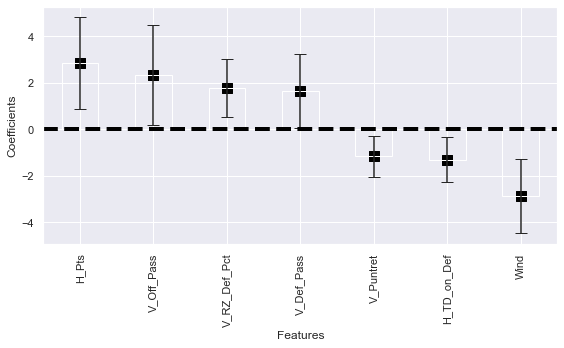

In [12]:
fig14, ax = plt.subplots(figsize=(8, 5))
plot_coef(scaled,fig14,ax,p_thresh=0.05)
ax.set_xlabel('Features')
ax.set_ylabel('Coefficients')
fig14.tight_layout()

**Digging a bit deeper, we can see the subtle difference in the relationship between** *V_Off_Pass* **and** *Total Points* **and the relationship between** *H_Off_Pass* **and** *Total Points*

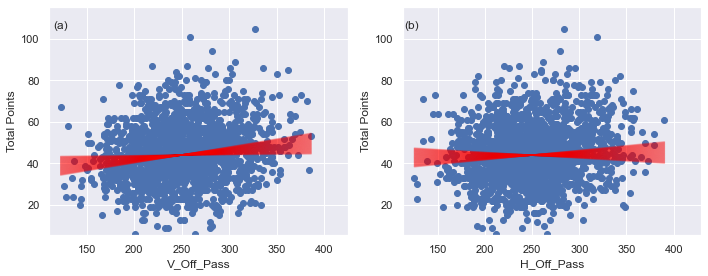

In [13]:
fig15 = plt.figure(figsize=(10,4))
cats = ['V_Off_Pass','H_Off_Pass']
df = pd.DataFrame({'V_Off_Pass':[0.004,0.077],'H_Off_Pass':[-0.028,0.046]},index=['min','max'])
lbl = ['(a)','(b)']
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
for i,cat in enumerate(cats):
    _ = fig15.add_subplot(1,2,i+1)
    x = dfgame[cat]
    min_m = df.loc['min',cat]
    max_m = df.loc['max',cat]
    mm = np.linspace(min_m,max_m,100)
    x0 = np.median(dfgame[cat])
    plt.scatter(x,y)
    plt.xlabel(cat)
    plt.ylabel('Total Points')
    plt.xlim(min(x)*0.9,max(x)*1.1)
    plt.ylim(min(y)*0.9,max(y)*1.1)
    plt.text(115,105,lbl[i],fontsize='medium')
    xx = np.linspace(min(x),max(x),500)
    b = y0-mm*x0
    for j in range(len(mm)):
        plt.plot(xx,mm[j]*xx+b[j],c='red',alpha=0.1)
fig15.tight_layout()

**With greater proportion of high visiting passing yards with high total points than low visiting passing yards with high total points**

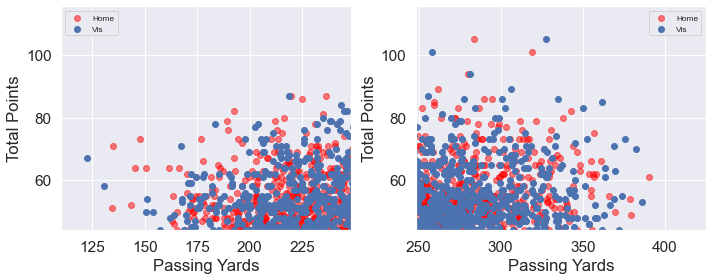

In [13]:
fig16 = plt.figure(figsize=(10,4))
cat = 'V_Off_Pass'
ovrlay = 'H_Off_Pass'
y = dfgame['Tot_Pts']
y0 = np.median(dfgame['Tot_Pts'])
x = dfgame[cat]
xover = dfgame[ovrlay]
_ = fig16.add_subplot(1,2,1)
plt.scatter(xover,y,c='red',alpha=0.5,label='Home')
plt.scatter(x,y,label='Vis')
plt.xlabel('Passing Yards')
plt.ylabel('Total Points')
plt.xlim(min(x)*0.9,np.median(x))
plt.ylim(np.median(y),max(y)*1.1)
plt.legend(loc='upper left',fontsize='small')
_ = fig16.add_subplot(1,2,2)
plt.scatter(xover,y,c='red',alpha=0.5,label='Home')
plt.scatter(x,y,label='Vis')
plt.xlabel('Passing Yards')
plt.ylabel('Total Points')
plt.xlim(np.median(x),max(x)*1.1)
plt.ylim(np.median(y),max(y)*1.1)
plt.legend(loc='upper right',fontsize='small')
fig16.tight_layout()
fig16.show()
fig16.savefig('plots/fig16.png',bbox_inches='tight')

### Outlier Detection & Handling

**Residual plot shows good distribution of residuals among predictions in base model**

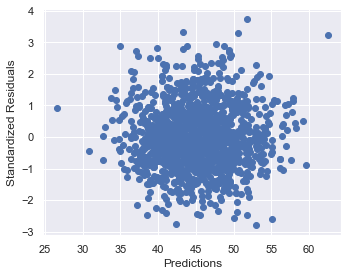

In [15]:
X, y = get_data()
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed, val=False)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
influence = model.get_influence()
inf = influence.summary_frame()
resid = influence.resid_studentized_external
ypred = model.predict(X_train)

figxx, ax2 = plt.subplots(1,1,figsize=(5,4))
ax2.scatter(ypred,resid)
ax2.set_xlabel('Predictions')
ax2.set_ylabel('Standardized Residuals')
figxx.tight_layout()

**Examining the effect of dropping influential points, the best results are obtained by dropping 0 or 
only the top 2 influential points**

0 observations dropped
2 observations dropped
6 observations dropped
28 observations dropped
67 observations dropped


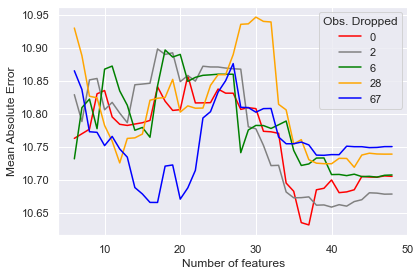

In [16]:
ndrops = [0,2,6,28,67]
n_splits = 5
mae_lists = []

X, y = get_data()
train_ratio = 0.60
valid_ratio = 0.15
X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, valid_ratio, seed=seed, val=True)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
influence = model.get_influence()
inf = influence.summary_frame()
resid = influence.resid_studentized_external
leverage = influence.hat_matrix_diag
inf_pts = pd.DataFrame({'resid':resid,'leverage':leverage},index=inf.index)
inf_pts['cooks'] = inf['cooks_d']
inf_pts['influence'] = inf_pts['cooks'] > inf_pts['cooks'].quantile(0.99)
to_drop = inf_pts['cooks'].sort_values(ascending=False).index.to_list()

for i,ndrop in enumerate(ndrops):
    print(f'{ndrop} observations dropped')
    mae_list = []
    X_train, X_val, X_test, y_train, y_val, y_test = tt_split(X, y, train_ratio, valid_ratio, seed=seed, val=True)
    X_train = X_train.drop(to_drop[0:ndrop],axis=0)
    y_train = y_train.drop(to_drop[0:ndrop],axis=0)
    model = linear_model.LinearRegression()
    GKF = GroupKFold(n_splits=n_splits)
    groups = group_labels(y_train,1/n_splits,seed=seed)
    for num_features in range (6,49):
        rfe = RFE(model,n_features_to_select=num_features)
        rfe.fit(X_train, y_train)
        sel_features = X_train.columns[np.nonzero(rfe.support_)].tolist()
        ypred = rfe.predict(X_val)
        m_score = mean_absolute_error(y_val,ypred)
        mae_list.append(m_score)
    mae_lists.append(mae_list)

fig18,ax1 = plt.subplots(1,1,figsize=(6,4))
colors = ['red','gray','green','orange','blue']
labels = ['0','2','6','28','67']
for i in range(len(mae_lists)):
    x = range(6,49)
    y = mae_lists[i]
    ax1.plot(x,y,color=colors[i],label=labels[i])
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Mean Absolute Error')
ax1.legend(title='Obs. Dropped')
fig18.tight_layout()

### Feature & Model Selection

**Optimized models with tuned hyperparameters, using 5-fold RFECV to select features**

In [17]:
n_splits = 5
min_selected_features = 37
train_ratio = 0.75

LR = linear_model.LinearRegression()
ridge = linear_model.Ridge(normalize=True)
XGB = xgb.XGBRegressor(eval_metric='mae',seed=seed)
RF = ensemble.RandomForestRegressor(random_state=seed,criterion='mae')

ridge_grid = {'alpha' : [0.44]}
forest_grid = {'n_estimators' : [25], 'max_depth' : [5], 'min_samples_leaf' : [1]}
boost_grid = {'colsample_bytree': [0.3], 'gamma': [0.0], 'learning_rate': [0.11],'max_depth': [3],
              'min_child_weight': [1], 'n_estimators': [50], 'reg_alpha': [0], 'subsample': [1.0]}

models = {'Linear Regression':{LR:{}},
          'Ridge':{ridge:ridge_grid},
          'XG Boost':{XGB:boost_grid},
          'Random Forest':{RF:forest_grid}}
coef_name = {LR:'LR.coef_',ridge:'ridge.coef_',XGB:'XGB.feature_importances_',RF:'RF.feature_importances_'}

X, y = get_data()

X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed, val=False)
GKF = GroupKFold(n_splits=n_splits)
groups = group_labels(y_train,1/n_splits,seed=seed)
scoring = make_scorer(mean_absolute_error,greater_is_better=False)


for name, d in models.items():
    print(name)
    for model, grid in d.items():
        for g in ParameterGrid(grid):
            model.set_params(**g)
            print(g)
            rfecv = RFECV(model, min_features_to_select=min_selected_features, 
                          cv=GKF.split(X_train,y_train,groups), scoring=scoring)
            rfecv.fit(X_train, y_train)
            best_num_features = rfecv.n_features_
            sel_features = X_train.columns[np.nonzero(rfecv.support_)].tolist()
            print(f'{best_num_features} Selected features: {sel_features}')
            print()
            ypred = rfecv.predict(X_test)
            acc,_ = ou_accuracy(y_test,ypred)
            print('MAE: {0:.3f}'.format(mean_absolute_error(y_test,ypred)))
            print('ACC: {0:.3f}'.format(acc))
            print()
            print()
        sca_train = robust.fit_transform(rfecv.transform(X_train))
        model.fit(sca_train,y_train)
        if ((name == 'Linear Regression') | (name == 'Ridge')):
            coef = get_coef(model.coef_,sel_features)
        else:
            coef = get_coef(model.feature_importances_,sel_features)
        print(coef.head(5))
        print()

Linear Regression
{}
38 Selected features: ['H_Pts', 'V_Pts', 'V_Pts_Opp', 'H_Off_Pass', 'H_Pass_Metric', 'V_Off_Pass', 'V_Pass_Metric', 'H_Off_Rush', 'H_Rush_Metric', 'V_Rush_Metric', 'H_Def_Pass', 'H_Def_Rush', 'V_Def_Rush', 'H_TD', 'V_TD', 'H_TD_on_Def', 'V_TD_on_Def', 'H_FG_Pct', 'V_FG_Pct', 'H_RZ_Pct', 'V_RZ_Pct', 'H_RZ_Def_Pct', 'V_RZ_Def_Pct', 'H_Poss', 'V_Poss', 'H_Plays', 'H_TO_Gain', 'V_TO_Gain', 'V_TO_Lost', 'V_Yds_Pen', 'H_Sacks_Def', 'V_Sacks_Def', 'H_Tackles_Loss', 'V_Tackles_Loss', 'V_Puntret', 'Wind', 'grass', 'dome']

MAE: 10.701
ACC: 0.520


               Coefficient
V_Off_Pass        5.055799
H_Pts             4.652661
V_Pass_Metric    -3.439774
Wind             -2.924203
H_Pass_Metric    -2.498253

Ridge
{'alpha': 0.44}
45 Selected features: ['H_Pts', 'H_Pts_Opp', 'V_Pts', 'V_Pts_Opp', 'H_Off_Pass', 'H_Pass_Metric', 'V_Off_Pass', 'H_Rush_Metric', 'V_Off_Rush', 'V_Rush_Metric', 'H_Def_Pass', 'V_Def_Pass', 'H_Def_Rush', 'V_Def_Rush', 'H_TD', 'V_TD', 'H_TD_on_Def', 'V

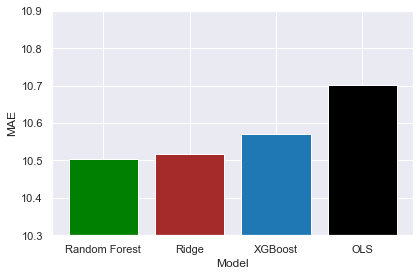

In [21]:
fig19, ax1 = plt.subplots(1,1,figsize=(6,4))
models = ['Random Forest','Ridge','XGBoost','OLS']
score = [10.505,10.516,10.571,10.701]
ax1.bar(models,score,color=['green','brown','#1f77b4','black'])
ax1.set_ylim(10.3,10.9)
ax1.set_xlabel('Model')
ax1.set_ylabel('MAE')
fig19.tight_layout()

### Threshold Tuning

Profits: [92, 112, 120, 118, 144, 163, 194, 204, 222, 225, 222, 179, 175, 173, 163, 165, 154, 132, 109, 96, 83, 75]
Returns per bet: [0.55, 0.53, 0.47, 0.38, 0.39, 0.38, 0.39, 0.35, 0.34, 0.29, 0.26, 0.24, 0.27, 0.31, 0.33, 0.4, 0.43, 0.44, 0.46, 0.51, 0.57, 0.63]
Accuracy: [0.8, 0.8, 0.77, 0.72, 0.73, 0.72, 0.72, 0.7, 0.7, 0.67, 0.65, 0.65, 0.66, 0.68, 0.69, 0.73, 0.74, 0.74, 0.76, 0.79, 0.82, 0.85]


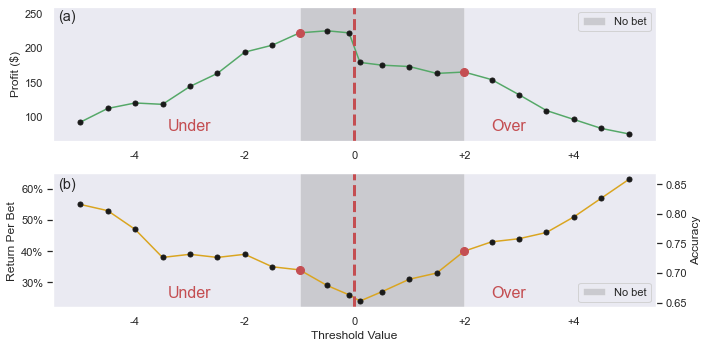

In [73]:
with open('data/df_2000_2019.pkl','rb') as f:
    dfall = pickle.load(f)
seed = 37
train_ratio=0.75
threshes = np.concatenate((np.arange(-5,0,0.5),np.array([-0.01]),np.array([0.01]),np.arange(0.5,5.5,0.5)))
model = ensemble.RandomForestRegressor(random_state=seed,criterion='mae',n_estimators=25, max_depth=5, 
                                       min_samples_leaf=1)

X, y = get_data()
# Feature set for optimized Random Forest model
X = X[['H_Pts', 'H_Pts_Opp', 'V_Pts', 'V_Pts_Opp', 'H_Off_Pass', 'H_Pass_Metric', 'V_Off_Pass', 
       'V_Pass_Metric', 'H_Off_Rush', 'H_Rush_Metric', 'V_Off_Rush', 'H_Def_Pass', 'V_Def_Pass', 'H_Def_Rush', 
       'V_Def_Rush', 'H_TD', 'H_FG_Pct', 'V_FG_Pct', 'H_RZ_Pct', 'V_RZ_Pct', 'H_RZ_Def_Pct', 'V_RZ_Def_Pct', 
       'H_Poss', 'V_Poss', 'H_Plays', 'V_Plays', 'H_TO_Gain', 'V_TO_Gain', 'H_Yds_Pen', 'V_Yds_Pen', 
       'V_Tackles_Loss', 'H_Kickret', 'V_Kickret', 'H_Puntret', 'V_Puntret', 'Temperature', 'Wind']]
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio, seed=seed, val=False)

## For training set
model.fit(X_train,y_train)
X_measured = X_train
y_measured = y_train
profits, perbets, acc, pctsofgames = list(), list(), list(), list()
ypred = model.predict(X_measured)
# Obtain Over/Unders for observations in training set
ou = dfall.loc[X_measured.index,'Over_Under']

for thresh in threshes:
    if thresh > 0:
        mask = (ypred - ou >= thresh)
        bets = pd.DataFrame({'Over_Under':ou[mask],'Predictions':ypred[mask],'Results':y_measured[mask]})
        winners = (bets['Results'] > bets['Over_Under']).sum()
        losers = (bets['Results'] < bets['Over_Under']).sum()
    else:
        mask = (ypred - ou) <= thresh
        bets = pd.DataFrame({'Over_Under':ou[mask],'Predictions':ypred[mask],'Results':y_measured[mask]})
        winners = (bets['Results'] < bets['Over_Under']).sum()
        losers = (bets['Results'] > bets['Over_Under']).sum()
    total = len(y_measured)
# pct = percentage of games bet
    pct = len(bets)/total
    pctsofgames.append(pct)
    prof = winners*0.9 - losers*1.0
# perbet = return per bet
    perbet = prof/len(bets)
    perbets.append(round(perbet,2))
# 16 total games per week, 100 dollars per bet    
    profits.append(round(perbet*16*pct*100))
    acc.append(round(winners/len(bets),2))
# Reposition all Over and all Under thresholds for better visibility on the graph
threshes[10] = -0.1
threshes[11] = 0.1
print(f'Profits: {profits}')
print(f'Returns per bet: {perbets}')
print(f'Accuracy: {acc}')

fig20, (ax1, ax2) = plt.subplots(2,1,figsize=(10,5))
ax1.plot(threshes,profits,marker='.',color='g',mfc='k',mec='k',ms=10)
ax1.set_ylabel('Profit ($)')
ax1.axvline(x=0,ls='--',color='r',lw=3)
ax1.text(2.5,80,'Over',color='r',fontsize=16)
ax1.text(-3.4,80,'Under',color='r',fontsize=16)
ax1.text(-5.4,240,'(a)',fontsize='large')
ax1.set_ylim(65,260)
ax1.set_xlim(-5.5,5.5)
ax1.xaxis.set_major_formatter(tick.FuncFormatter(x_tk_fmt))
ax1.grid(False)
ax1.fill_between(x=np.array([-1,2.0]),y1=65,y2=260,facecolor='gray',alpha=0.3,label='No bet')
ax1.plot(threshes[8],profits[8],marker='.',mfc='r',mec='r',ms=16)
ax1.plot(threshes[15],profits[15],marker='.',mfc='r',mec='r',ms=16)
ax1.legend(loc=1)
ax2.plot(threshes,perbets,marker='.',color='goldenrod',mfc='k',mec='k',ms=10)
ax2.set_ylabel('Return Per Bet')
ax2.axvline(x=0,ls='--',color='r',lw=3)
ax2.text(2.5,0.25,'Over',color='r',fontsize=16)
ax2.text(-3.4,0.25,'Under',color='r',fontsize=16)
ax2.text(-5.4,0.6,'(b)',fontsize='large')
ax2.plot(threshes[8],perbets[8],marker='.',mfc='r',mec='r',ms=16)
ax2.plot(threshes[15],perbets[15],marker='.',mfc='r',mec='r',ms=16)
ax2.fill_between(x=np.array([-1,2.0]),y1=0.22,y2=0.65,facecolor='gray',alpha=0.3,label='No bet')
ax2.legend(loc=4)
pbmin = 0.22
pbmax = 0.65
ax2.set_ylim(pbmin,pbmax)
ax2.set_xlim(-5.5,5.5)
ax2.xaxis.set_major_formatter(tick.FuncFormatter(x_tk_fmt))
ax2.yaxis.set_major_formatter(tick.PercentFormatter(1,decimals=0))
ax2.set_xlabel('Threshold Value')
ax2.grid(False)
ax3 = ax2.twinx()
ax3.set_ylabel('Accuracy')
ax3.grid(False)
accmin = (1+pbmin)/1.9
accmax = (1+pbmax)/1.9
ax3.set_ylim(accmin,accmax)
fig20.tight_layout()
fig20.savefig('plots/fig20.png',bbox_inches='tight')

In [60]:
## For test set
X_measured = X_test
y_measured = y_test
profits, perbets, acc, pctsofgames = list(), list(), list(), list()
ypred = model.predict(X_measured)
ou = dfall.loc[X_measured.index,'Over_Under']

for thresh in threshes:
    if thresh > 0:
        mask = (ypred - ou >= thresh)
        bets = pd.DataFrame({'Over_Under':ou[mask],'Predictions':ypred[mask],'Results':y_measured[mask]})
        winners = (bets['Results'] > bets['Over_Under']).sum()
        losers = (bets['Results'] < bets['Over_Under']).sum()
    else:
        mask = (ypred - ou) <= thresh
        bets = pd.DataFrame({'Over_Under':ou[mask],'Predictions':ypred[mask],'Results':y_measured[mask]})
        winners = (bets['Results'] < bets['Over_Under']).sum()
        losers = (bets['Results'] > bets['Over_Under']).sum()
    total = len(y_measured)
    pct = len(bets)/total
    pctsofgames.append(pct)
    prof = winners*0.9 - losers*1.0
    perbet = prof/len(bets)
    perbets.append('{:.2f}'.format(perbet))
    p = '{:.0f}'.format(perbet*16*pct*100)
    profits.append(p)
    a = '{:.2f}'.format(winners/len(bets))
    acc.append(a)
print(f'Profits: {profits}')
print(f'Returns per bet: {perbets}')
print(f'Accuracy: {acc}')

Profits: ['-24', '-5', '7', '32', '39', '29', '19', '8', '9', '21', '45', '42', '31', '18', '53', '29', '13', '9', '33', '47', '63', '47']
Returns per bet: ['-0.19', '-0.03', '0.04', '0.12', '0.12', '0.07', '0.04', '0.02', '0.01', '0.03', '0.06', '0.05', '0.04', '0.03', '0.09', '0.06', '0.03', '0.03', '0.13', '0.25', '0.44', '0.43']
Accuracy: ['0.42', '0.51', '0.55', '0.59', '0.59', '0.56', '0.55', '0.53', '0.53', '0.54', '0.55', '0.55', '0.54', '0.53', '0.57', '0.55', '0.54', '0.53', '0.59', '0.65', '0.74', '0.73']


### Summary

- **Features associated with scoring, passing offense and defense, visiting defensive red-zone proficiency, and wind are most correlated with Total Points. Rushing features not highly significant**
- **Visiting defensive red-zone percentage has a relatively much stronger relationship with** *Total Points* **than with** *Over/Under*
- **Large number of features required; more visiting features among most important**
- **Random Forest model with 37 features gives the best results**
- **Threshold of -1 and +2 gives optimal results**